For example, a project that performs various binary classification methods on a social science dataset you may want to focus on data munging, method selection, method evaluation, feature extraction, and presentation of analysis.

# Prediction of stock raise/fall using state-of-the-art Machine Learning and Deep Learning methods.

## STA208 Final project

Sample outline:

1. Introduction
   - stock price prediction challanges, relation to news, why ML and Deep learning approach might work
2. data munging and feature extraction
   - scraping of news data from motleyfool.com
   - getting the sentiment scores using the dictionary of positive and negative words
   - designing a "sentiment" feature, word cloud for one POSITIVE and one NEGATIVE articles
   - quandl.api to get the data, etc...
3. method selection, evaluation, and comparison
   - baseline classification methods, logistic regression, SVM, random forest
   - feed forward neural nets, recurrent neural nets (description also)
   - tuning the neural net parameters, etc.
4. results and conclusion
   - comparison of accuracy results, confusion matrix, ROC, PR, curves, etc.

# 1. Introduction

general

# 2. Data Munging and Feature Extraction

1. www.motleyfool.com scraping

In [ ]:
import requests
import requests_ftp
import requests_cache
import lxml
import itertools
import pandas as pd
import re
import numpy as np
import string
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from scipy.misc import imread
plt.style.use('ggplot')

In [ ]:
def motley_page_links(page):
    """
    Given a page number, it returns all article links.
    
    Input: a page number (default = 1)
    Output: a list with links on the given page
    """
    
    response = requests.get(
        'https://www.fool.com/search/solr.aspx?page={}&q=apple&sort=date&source=isesitbut0000001'.format(page))
    response.raise_for_status()
    html = response.text
    parsed_html = BeautifulSoup(html, 'lxml')

    div_with_links = parsed_html.find_all(name = 'dl',
                                         attrs = {'class' : 'results'})
    links = []
    for link in div_with_links[0].find_all('a', href = True):
        links.append(link['href'])
    
    return links

def motley_all_links(no_pages = 1):
    """
    Given number of pages, it returns all the links 
    from "no_pages"
    
    Input: number of pages (default = 1)
    Output: a list with links from the pages
    """
    all_links = []
    for page in range(1, (no_pages + 1)):
        all_links.extend(motley_page_links(page))
    
    return all_links

def motley_article_info(url):
    """
    Given an article url, it returns title, date, content
    and url of that article.
    
    Input: article url
    Ouput: a dictionary with 'title', 'date',
    'article', and 'url' as keys.
    """
    
    response = requests.get(url)
    response.raise_for_status()
    html = response.text
    parsed_html = BeautifulSoup(html, 'lxml')
    content = parsed_html.find_all(name = 'div',
                                      attrs = {'class' : 'full_article'})

    date = parsed_html.find_all(name = 'div', attrs = {'class' : 'publication-date'})[0].text.strip()
    title = parsed_html.find_all('h1')[0].text
    article = ' '.join([t.text for t in content[0].find_all('p')])
    
    return {'title'   : title,
            'date'    : date,
            'article' : article,
            'url'     : url}

def motley_df(no_pages):
    """
    Creates DataFrame for the articles in url
    with author, text, title, and url as column
    names.
    
    Input: A url, number of pages
    Output: DataFrame with 4 columns: author,
    text, title, and url.
    """
    
    #get all links in the specified number of pages
    #from url
    links = motley_all_links(no_pages)
    
    #create dataframe for each link and
    #combine them into one dataframe
    article_df = pd.DataFrame(index = [999999], columns=['article', 'date', 'title', 'url'])
    for i, link in enumerate(links):
        try:
            append_to = pd.DataFrame(motley_article_info(link), index = [i])
            article_df = article_df.append(append_to)
        except:
            pass
    
    article_df = article_df.drop(999999)
    return article_df

#df = motley_df(1000)
#convert_to_csv(df, "motleyfool.csv")

2.
sentiment scoring

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
motley = pd.read_csv('motleyfool.csv')

negative = pd.read_csv('negative-words.txt', sep = ' ', header = None)
positive = pd.read_csv('positive-words.txt', sep=' ', header=None)

def score_word(word):
    """
    returns -1 if negative meaning, +1 if positive meaning,
    else 0
    
    input: a word
    ouput: -1, 0, or + 1
    """
    if word.lower() in negative.values:
        return -1
    elif word.lower() in positive.values:
        return +1
    return 0

def get_scores(article):
    """
    returns sentiment scores for a given article
    
    input: an article
    output: sentiment score
    """
    wordsArticle = article.split(' ')
    scores = [score_word(word) for word in wordsArticle]
    return sum(scores)

motley['sentiment'] = motley['article'].apply(get_scores)

plt.hist(motley.sentiment, bins=50)
plt.xlabel('sentiment scores')
plt.ylabel('frequency')
plt.title('Distribution of sentiment scores of articles');

# motley.to_csv('motley_with_s_scores.csv', encoding='utf-8')

3.
merging data sets

APPLE stock data was obtained using "quandl.com" API at "https://www.quandl.com/api/v3/datasets/WIKI/AAPL.csv"

In [ ]:
aapl = pd.read_csv(path+'WIKI_PRICES_AAPL.csv')
fool = pd.read_csv(path+'motley_with_s_scores.csv')

In [ ]:
def format_df(stock_df, news_df, word):
    """
    merges stock_df and news_df on "date"
    column
    
    input: stock df, news df, word
    output: merged df
    """
    
    stock_df['diff'] = stock_df['close']-stock_df['open']
    news_df['Count'] = news_df['article'].apply(lambda x: x.count(word))
    news_df.loc[news_df['Count'] <= 5, 'sentiment'] = 0
    news_df['date'] = pd.to_datetime(news_df['date'])
    news_df['date'] = news_df['date'].dt.strftime('%Y-%m-%d')
    news_df = news_df.groupby(['date'], as_index = False).sum()
    news_df = news_df[['date', 'sentiment', 'Count']]
    merged_df = pd.merge(news_df, stock_df)
    merged_df['bin_sentiment'] = pd.cut(merged_df['sentiment'], [-np.inf, -0.001, 0.001, np.inf], labels = [-1, 0, 1])
    merged_df['bin_diff'] = pd.cut(merged_df['diff'], [-np.inf, -0.001, 0.001, np.inf], labels = [-1, 0, 1])
    return merged_df

In [ ]:
merged_df = format_df(aapl, fool, 'Apple')
merged_df.head()
#merged_df.to_csv('merged_df.csv', encoding='utf-8')

# 3. Methods selection, evaluation

write more about it

In [1]:
import tensorflow as tf
from  tensorflow.contrib.learn.python.learn.estimators.dnn  import DNNClassifier
from tensorflow.contrib.layers import real_valued_column

In [113]:
apple = pd.read_csv('merged_df.csv')

In [115]:
apple.head()

,Unnamed: 0,date,sentiment,Count,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,diff,bin_sentiment,bin_diff
0,0,2014-05-05,53,133,AAPL,590.14,601.0000,590.00,600.9600,10252400.0,0.00,1.0,79.229879,80.687900,79.211083,80.682530,71766800.0,10.8200,1,1
1,1,2014-05-06,15,177,AAPL,601.80,604.4099,594.41,594.4100,13377300.0,0.00,1.0,80.795305,81.145700,79.803152,79.803152,93641100.0,-7.3900,1,-1
2,2,2014-05-07,40,134,AAPL,595.25,597.2900,587.73,592.3300,10102300.0,0.00,1.0,79.915927,80.189810,78.906322,79.523900,70716100.0,-2.9200,1,-1
3,3,2014-05-08,31,109,AAPL,588.25,594.4100,586.40,587.9900,8224900.0,3.29,1.0,79.418033,80.249678,79.168269,79.382931,57574300.0,-0.2600,1,-1
4,4,2014-05-09,3,67,AAPL,584.54,586.2500,580.33,585.5425,10414200.0,0.00,1.0,78.917156,79.148018,78.348775,79.052500,72899400.0,1.0025,1,1


In [334]:
aapl = apple.copy()[['date', 'adj_volume', 'sentiment', 'bin_diff']]
aapl.head()

,date,adj_volume,sentiment,bin_diff
0,2014-05-05,71766800.0,53,1
1,2014-05-06,93641100.0,15,-1
2,2014-05-07,70716100.0,40,-1
3,2014-05-08,57574300.0,31,-1
4,2014-05-09,72899400.0,3,1


In [434]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1)

In [336]:
InputDF = aapl.copy().drop('bin_diff', axis = 1)
InputDF = InputDF.set_index('date')

In [340]:
label = pd.qcut(apple['diff'], 2,labels=range(2))

In [341]:
label.values

[1, 0, 0, 0, 1, ..., 0, 0, 1, 0, 1]
Length: 779
Categories (2, int64): [0 < 1]

In [342]:
InputDF.head()

,adj_volume,sentiment
date,,
2014-05-05,71766800.0,53
2014-05-06,93641100.0,15
2014-05-07,70716100.0,40
2014-05-08,57574300.0,31
2014-05-09,72899400.0,3


In [343]:
InputDF = InputDF.apply(lambda x:(x -x.mean())/x.std())

In [344]:
InputDF.head()

,adj_volume,sentiment
date,,
2014-05-05,1.255323,0.693098
2014-05-06,2.270155,-0.496574
2014-05-07,1.206577,0.286105
2014-05-08,0.596879,0.004340
2014-05-09,1.307868,-0.872260


In [345]:
test_size = 600
xtrain, xtest = InputDF.iloc[:test_size, :], InputDF.iloc[test_size:, :]
ytrain, ytest = label[:test_size], label[test_size:]

## Support Vector Machines

             precision    recall  f1-score   support

          0       0.45      0.73      0.55        83
          1       0.48      0.21      0.29        96

avg / total       0.46      0.45      0.41       179

[[61 22]
 [76 20]]


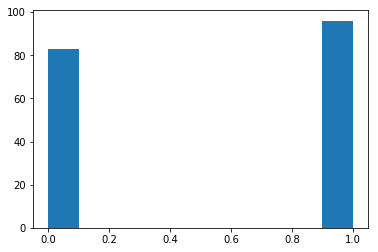

In [435]:
from sklearn.svm import SVC
svm = SVC()
res = svm.fit(xtrain, ytrain)

from sklearn.metrics import classification_report,confusion_matrix

print (classification_report(ytest , res.predict(xtest)))
print (confusion_matrix(ytest, res.predict(xtest)))
plt.hist(ytest);

## Logistic regression

             precision    recall  f1-score   support

          0       0.46      0.66      0.54        83
          1       0.53      0.33      0.41        96

avg / total       0.50      0.49      0.47       179

[[55 28]
 [64 32]]


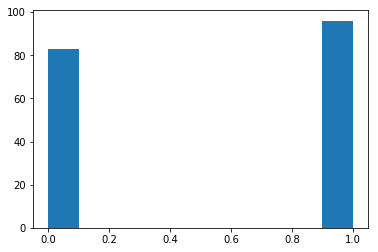

In [436]:
res = logreg.fit(xtrain, ytrain)

from sklearn.metrics import classification_report,confusion_matrix

print (classification_report(ytest , res.predict(xtest)))
print (confusion_matrix(ytest, res.predict(xtest)))
plt.hist(ytest);

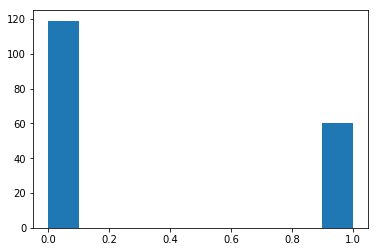

In [437]:
plt.hist(res.predict(xtest));

## Random Forest Tree Classifiers

## Feed Forward Neural Network

In [465]:
num_features = len(InputDF.columns)
dropout=0.2
hidden_1_size = 25
hidden_2_size = 5
num_classes = label.nunique()
NUM_EPOCHS=20
BATCH_SIZE=1
lr=0.0001
np.random.RandomState(52);

In [466]:
val = (InputDF[:-test_size].values, label[:-test_size].values)
train = (InputDF[-test_size:].values, label[-test_size:].values)
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[1])/BATCH_SIZE)

In [467]:
class Model():
    def __init__(self):
        global_step = tf.contrib.framework.get_or_create_global_step()
        self.input_data = tf.placeholder(dtype=tf.float32,shape=[None,num_features])
        self.target_data = tf.placeholder(dtype=tf.int32,shape=[None])
        self.dropout_prob = tf.placeholder(dtype=tf.float32,shape=[])
        with tf.variable_scope("ff"):
            droped_input = tf.nn.dropout(self.input_data,keep_prob=self.dropout_prob)
            
            layer_1 = tf.contrib.layers.fully_connected(
                num_outputs=hidden_1_size,
                inputs=droped_input,
            )
            layer_2 = tf.contrib.layers.fully_connected(
                num_outputs=hidden_2_size,
                inputs=layer_1,
            )
            self.logits = tf.contrib.layers.fully_connected(
                num_outputs=num_classes,
                activation_fn =None,
                inputs=layer_2,
            )
        with tf.variable_scope("loss"):
            
            self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                         labels = self.target_data)
            mask = (1-tf.sign(1-self.target_data)) #Don't give credit for flat days
            mask = tf.cast(mask,tf.float32)
            self.loss = tf.reduce_sum(self.losses)
        
        with tf.name_scope("train"):
            opt = tf.train.AdamOptimizer(lr)
            gvs = opt.compute_gradients(self.loss)
            self.train_op = opt.apply_gradients(gvs, global_step=global_step)
        
        with tf.name_scope("predictions"):
            self.probs = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(self.probs, 1)
            correct_pred = tf.cast(tf.equal(self.predictions, tf.cast(self.target_data,tf.int64)),tf.float64)
            self.accuracy = tf.reduce_mean(correct_pred)

In [468]:
with tf.Graph().as_default():
    model = Model()
    input_ = train[0]
    target = train[1]
    losses = []
    with tf.Session() as sess:
        init = tf.initialize_all_variables()
        sess.run([init])
        epoch_loss =0
        for e in range(NUM_EPOCHS):
            if epoch_loss >0 and epoch_loss <1:
                break
            epoch_loss =0
            for batch in range(0,NUM_TRAIN_BATCHES):
                
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:input_[start:end],
                    model.target_data:target[start:end],
                    model.dropout_prob:0.9
                            }
                
                _,loss,acc = sess.run(
                    [
                        model.train_op,
                        model.loss,
                        model.accuracy,
                    ]
                    ,feed_dict=feed
                )
                epoch_loss+=loss
            losses.append(epoch_loss)
            print('step - {0} loss - {1} acc - {2}'.format((1+batch+NUM_TRAIN_BATCHES*e),epoch_loss,acc))
                
        
        print('done training')
        final_preds =np.array([])
        final_probs =None
        for batch in range(0,NUM_VAL_BATCHES):
            
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:val[0][start:end],
                    model.target_data:val[1][start:end],
                    model.dropout_prob:1
                            }
                
                acc,preds,probs = sess.run(
                    [
                        model.accuracy,
                        model.predictions,
                        model.probs
                    ]
                    ,feed_dict=feed
                )
                print(acc)
                final_preds = np.concatenate((final_preds,preds),axis=0)
                if final_probs is None:
                    final_probs = probs
                else:
                    final_probs = np.concatenate((final_probs,probs),axis=0)
        prediction_conf = final_probs[np.argmax(final_probs, 1)]

Instructions for updating:
Use `tf.global_variables_initializer` instead.
step - 600 loss - 419.2093040943146 acc - 1.0
step - 1200 loss - 417.2555048465729 acc - 1.0
step - 1800 loss - 417.2346202135086 acc - 1.0
step - 2400 loss - 416.2016576528549 acc - 1.0
step - 3000 loss - 415.71979638934135 acc - 1.0
step - 3600 loss - 414.8969846665859 acc - 1.0
step - 4200 loss - 415.8810990154743 acc - 1.0
step - 4800 loss - 415.78498965501785 acc - 1.0
step - 5400 loss - 414.56457966566086 acc - 1.0
step - 6000 loss - 414.3590054810047 acc - 1.0
step - 6600 loss - 414.5243852734566 acc - 1.0
step - 7200 loss - 413.4972666800022 acc - 1.0
step - 7800 loss - 414.7007949948311 acc - 1.0
step - 8400 loss - 415.1870813071728 acc - 1.0
step - 9000 loss - 413.92336907982826 acc - 0.0
step - 9600 loss - 414.7711333334446 acc - 1.0
step - 10200 loss - 413.981097638607 acc - 0.0
step - 10800 loss - 413.9152930676937 acc - 1.0
step - 11400 loss - 413.7775710821152 acc - 0.0
step - 12000 loss - 414.0470

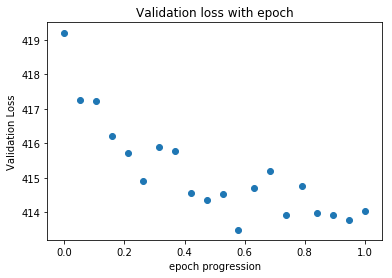

In [469]:
plt.scatter(np.linspace(0, 1, len(losses)), losses);
plt.title('Validation loss with epoch')
plt.ylabel('Validation Loss')
plt.xlabel('epoch progression');

In [470]:
print (classification_report(ytest.values, final_preds))
print (confusion_matrix(ytest, final_preds))

             precision    recall  f1-score   support

          0       0.44      0.51      0.47        83
          1       0.51      0.44      0.47        96

avg / total       0.47      0.47      0.47       179

[[42 41]
 [54 42]]


# Recursive Neural Nets

In [489]:
from tensorflow.contrib.layers.python.layers.initializers import xavier_initializer
from tensorflow.contrib import rnn

RNN_HIDDEN_SIZE=4
FIRST_LAYER_SIZE=50
SECOND_LAYER_SIZE=10
NUM_LAYERS=2
BATCH_SIZE=1
NUM_EPOCHS=25
lr=0.0003
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[1])/BATCH_SIZE)
ATTN_LENGTH=30
beta=0
np.random.RandomState(52);

In [490]:
class RNNModel():
    def __init__(self):
        global_step = tf.contrib.framework.get_or_create_global_step()
        self.input_data = tf.placeholder(dtype=tf.float32,shape=[BATCH_SIZE,num_features])
        self.target_data = tf.placeholder(dtype=tf.int32,shape=[BATCH_SIZE])
        self.dropout_prob = tf.placeholder(dtype=tf.float32,shape=[])
        
        def makeGRUCells():
            base_cell = rnn.GRUCell(num_units=RNN_HIDDEN_SIZE,) 
            layered_cell = rnn.MultiRNNCell([base_cell] * NUM_LAYERS,state_is_tuple=False) 
            attn_cell =tf.contrib.rnn.AttentionCellWrapper(cell=layered_cell,attn_length=ATTN_LENGTH,state_is_tuple=False)
            return attn_cell
        
        self.gru_cell = makeGRUCells()
        self.zero_state = self.gru_cell.zero_state(1, tf.float32)
        
        self.start_state = tf.placeholder(dtype=tf.float32,shape=[1,self.gru_cell.state_size])
        
        

        with tf.variable_scope("ff",initializer=xavier_initializer(uniform=False)):
            droped_input = tf.nn.dropout(self.input_data,keep_prob=self.dropout_prob)
            
            layer_1 = tf.contrib.layers.fully_connected(
                num_outputs=FIRST_LAYER_SIZE,
                inputs=droped_input,
                
            )
            layer_2 = tf.contrib.layers.fully_connected(
                num_outputs=RNN_HIDDEN_SIZE,
                inputs=layer_1,
                
            )
            
        
        split_inputs = tf.reshape(droped_input,shape=[1,BATCH_SIZE,num_features],name="reshape_l1") # Each item in the batch is a time step, iterate through them
        split_inputs = tf.unstack(split_inputs,axis=1,name="unpack_l1")
        states =[]
        outputs =[]
        with tf.variable_scope("rnn",initializer=xavier_initializer(uniform=False)) as scope:
            state = self.start_state
            for i, inp in enumerate(split_inputs):
                if i >0:
                    scope.reuse_variables()
                
                output, state = self.gru_cell(inp, state)
                states.append(state)
                outputs.append(output)
        self.end_state = states[-1]
        outputs = tf.stack(outputs,axis=1) # Pack them back into a single tensor
        outputs = tf.reshape(outputs,shape=[BATCH_SIZE,RNN_HIDDEN_SIZE])
        self.logits = tf.contrib.layers.fully_connected(
            num_outputs=num_classes,
            inputs=outputs,
            activation_fn=None
        )

            
        with tf.variable_scope("loss"):
            self.penalties =    tf.reduce_sum([beta*tf.nn.l2_loss(var) for var in tf.trainable_variables()])

            
            self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.logits,
                                                                         labels = self.target_data)
            self.loss = tf.reduce_sum(self.losses + beta*self.penalties)
        
        with tf.name_scope("train_step"):
            opt = tf.train.AdamOptimizer(lr)
            gvs = opt.compute_gradients(self.loss)
            self.train_op = opt.apply_gradients(gvs, global_step=global_step)
        
        with tf.name_scope("predictions"):
            probs = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(probs, 1)
            correct_pred = tf.cast(tf.equal(self.predictions, tf.cast(self.target_data,tf.int64)),tf.float64)
            self.accuracy = tf.reduce_mean(correct_pred)

# training the RNN

In [491]:
with tf.Graph().as_default():
    model = RNNModel()
    input_ = train[0]
    target = train[1]
    losses = []
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run([init])
        loss = 2000
        
        for e in range(NUM_EPOCHS):
            state = sess.run(model.zero_state)
            epoch_loss =0
            for batch in range(0,NUM_TRAIN_BATCHES):
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:input_[start:end],
                    model.target_data:target[start:end],
                    model.dropout_prob:0.5,
                    model.start_state:state
                            }
                _,loss,acc,state = sess.run(
                    [
                        model.train_op,
                        model.loss,
                        model.accuracy,
                        model.end_state
                    ]
                    ,feed_dict=feed
                )
                epoch_loss+=loss
            losses.append(epoch_loss)
            print('step - {0} loss - {1} acc - {2}'.format((e),epoch_loss,acc))
        final_preds =np.array([])
        for batch in range(0,NUM_VAL_BATCHES):
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:val[0][start:end],
                    model.target_data:val[1][start:end],
                    model.dropout_prob:1,
                    model.start_state:state
                            }
                acc,preds,state = sess.run(
                    [
                        model.accuracy,
                        model.predictions,
                        model.end_state
                    ]
                    ,feed_dict=feed
                )
                print(acc)
                assert len(preds) == BATCH_SIZE
                final_preds = np.concatenate((final_preds,preds),axis=0)

step - 0 loss - 417.21387165784836 acc - 0.0
step - 1 loss - 416.0871697664261 acc - 0.0
step - 2 loss - 415.7393709421158 acc - 0.0
step - 3 loss - 416.2393338084221 acc - 0.0
step - 4 loss - 415.31454586982727 acc - 0.0
step - 5 loss - 416.07181894779205 acc - 1.0
step - 6 loss - 415.53357696533203 acc - 0.0
step - 7 loss - 415.31331557035446 acc - 0.0
step - 8 loss - 415.38470923900604 acc - 0.0
step - 9 loss - 415.98950189352036 acc - 0.0
step - 10 loss - 414.35794323682785 acc - 0.0
step - 11 loss - 414.7595503926277 acc - 1.0
step - 12 loss - 415.2831164598465 acc - 0.0
step - 13 loss - 416.1695525050163 acc - 0.0
step - 14 loss - 414.42500281333923 acc - 1.0
step - 15 loss - 415.21704733371735 acc - 1.0
step - 16 loss - 415.33552449941635 acc - 1.0
step - 17 loss - 414.18447881937027 acc - 1.0
step - 18 loss - 415.9529753923416 acc - 1.0
step - 19 loss - 414.1148049235344 acc - 0.0
step - 20 loss - 415.9385293126106 acc - 1.0
step - 21 loss - 414.4861587882042 acc - 1.0
step - 2

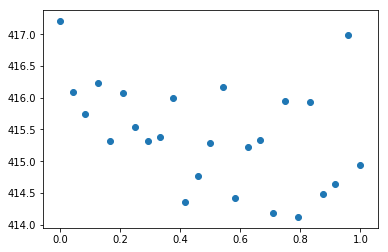

In [492]:
plt.scatter(np.linspace(0, 1, len(losses)), losses);

In [493]:
print (classification_report(ytest.values, final_preds))
print (confusion_matrix(ytest, final_preds))

             precision    recall  f1-score   support

          0       0.45      0.39      0.42        83
          1       0.53      0.59      0.56        96

avg / total       0.49      0.50      0.49       179

[[32 51]
 [39 57]]
